In [1]:
import eikon as ek
import numpy as np
import pandas as pd
import json
import datetime as dt
import traceback
import math

# Import Cleaned Data

In [2]:
price_data = pd.read_csv("price_data_cleaned.csv")

In [3]:
price_data.describe()

,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,C3 - Close Price,C3 - Accumulated Volume,C4 - Close Price,C4 - Accumulated Volume,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return
count,166554.000000,166554.000000,166554.000000,166554.000000,166554.000000,1.664290e+05,166554.000000,1.665070e+05,162312.000000,1.622760e+05,162312.000000,1.622760e+05,166554.000000,166554.000000,162726.000000,162726.000000
mean,2007.503032,6.555964,15.772128,2.014272,2247.252814,1.925024e+05,2248.873235,1.765483e+05,2290.334560,4.550426e+04,2290.334560,4.550426e+04,0.000187,0.000119,0.000135,0.000135
std,8.644937,3.433873,8.750959,1.399904,10215.661480,3.268517e+06,10218.444864,2.920270e+06,10305.344406,1.103189e+06,10305.344406,1.103189e+06,0.016653,0.015798,0.014556,0.014556
min,1992.000000,1.000000,1.000000,0.000000,-13.100000,0.000000e+00,0.302000,0.000000e+00,0.308000,0.000000e+00,0.308000,0.000000e+00,-0.359333,-0.941776,-0.261407,-0.261407
25%,2000.000000,4.000000,8.000000,1.000000,19.490000,7.530000e+02,19.430000,2.519000e+03,19.800000,9.200000e+02,19.800000,9.200000e+02,-0.006027,-0.005932,-0.005422,-0.005422
50%,2008.000000,7.000000,16.000000,2.000000,111.450000,4.979000e+03,111.700000,1.022200e+04,112.850000,4.084000e+03,112.850000,4.084000e+03,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,10.000000,23.000000,3.000000,502.750000,2.227400e+04,506.875000,3.527050e+04,524.000000,1.610625e+04,524.000000,1.610625e+04,0.006370,0.006090,0.005732,0.005732
max,2021.000000,12.000000,31.000000,6.000000,155880.000000,1.734515e+08,154750.000000,2.790027e+08,154540.000000,1.340868e+08,154540.000000,1.340868e+08,0.479290,0.387716,0.409346,0.409346


# Create Carry Signals & Trading Data Set

In [4]:
price_data["C1 - C2 Carry"] = price_data["C2 - Close Price"] / price_data["Close Price"] - 1

In [5]:
price_data["Instrument - Lag"] = price_data.Instrument.shift(1)
price_data["Date - Lag"] = price_data.Date.shift(1)
price_data["C2 - Close Price - Lag"] = price_data["C2 - Close Price"].shift(1)
price_data["Close Price - Lag"] = price_data["Close Price"].shift(1)
price_data["C1 - C2 Carry - Lag"] = price_data["C1 - C2 Carry"].shift(1)

In [6]:
price_data["Date - Lag"] = price_data[["Instrument - Lag", "Instrument", "Date - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C2 - Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "C2 - Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C1 - C2 Carry - Lag"] = price_data[["Instrument - Lag", "Instrument", "C1 - C2 Carry - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

In [7]:
trading_data = price_data.copy()

In [8]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag
0,SB,1992-01-03,1992,1,3,4,8.410,5154.0,8.370,3388.0,...,-0.020955,-0.018757,-0.012972,-0.012972,-0.004756,NaN,NaN,NaN,NaN,NaN
1,SB,1992-01-06,1992,1,6,0,8.500,4996.0,8.440,2751.0,...,0.010702,0.008363,0.003584,0.003584,-0.007059,SB,1992-01-03,8.370,8.410,-0.004756
2,SB,1992-01-07,1992,1,7,1,8.350,4846.0,8.320,4290.0,...,-0.017647,-0.014218,-0.007143,-0.007143,-0.003593,SB,1992-01-06,8.440,8.500,-0.007059
3,SB,1992-01-08,1992,1,8,2,8.430,5456.0,8.460,4665.0,...,0.009581,0.016827,0.014388,0.014388,0.003559,SB,1992-01-07,8.320,8.350,-0.003593
4,SB,1992-01-09,1992,1,9,3,8.450,4213.0,8.440,4566.0,...,0.002372,-0.002364,0.001182,0.001182,-0.001183,SB,1992-01-08,8.460,8.430,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,SI,2021-12-27,2021,12,27,0,22.680,1.0,23.060,108793.0,...,0.000000,0.000000,0.000000,0.000000,0.016755,SI,2021-12-23,22.895,22.835,0.002628
166550,SI,2021-12-28,2021,12,28,1,23.150,211.0,23.015,73451.0,...,0.000000,0.000000,0.000000,0.000000,-0.005832,SI,2021-12-27,23.060,22.680,0.016755
166551,SI,2021-12-29,2021,12,29,2,22.635,172.0,22.825,98976.0,...,0.000000,0.000000,0.000000,0.000000,0.008394,SI,2021-12-28,23.015,23.150,-0.005832
166552,SI,2021-12-30,2021,12,30,3,23.070,344.0,23.100,75359.0,...,0.000000,0.000000,0.000000,0.000000,0.001300,SI,2021-12-29,22.825,22.635,0.008394


In [9]:
trading_data.Date = pd.to_datetime(trading_data.Date)

Value Baseline

To calculate the value factor we need the average price over the past 5 years. The average excludes the current date to prevent forward-looking bias

In [10]:
trading_data.sort_values(["Instrument", "Date"], ascending=True, inplace=True)

trading_data["5Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "1825d",
    on="Date",
    closed="neither"
)["Close Price"].mean().to_numpy()

trading_data["C2 - 5Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "1825d",
    on="Date",
    closed="neither"
)["C2 - Close Price"].mean().to_numpy()

In [11]:
min_dates = trading_data.groupby("Instrument").agg(
    min_date = ("Date", "min")
).reset_index()

trading_data = trading_data.merge(min_dates, how="left")

trading_data["5Y Average Price"] = trading_data[[
    "5Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 1825 else np.nan, axis=1
)
trading_data["C2 - 5Y Average Price"] = trading_data[[
    "C2 - 5Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 1825 else np.nan, axis=1
)

In [12]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag,5Y Average Price,C2 - 5Y Average Price,min_date
0,C,1992-01-03,1992,1,3,4,248.75,23080.0,254.25,5508.0,...,-0.006699,0.022111,KW,NaN,NaN,NaN,NaN,NaN,NaN,1992-01-03
1,C,1992-01-06,1992,1,6,0,250.00,20980.0,256.00,4266.0,...,0.005780,0.024000,C,1992-01-03,254.25,248.75,0.022111,NaN,NaN,1992-01-03
2,C,1992-01-07,1992,1,7,1,249.75,11869.0,256.00,4310.0,...,0.001916,0.025025,C,1992-01-06,256.00,250.00,0.024000,NaN,NaN,1992-01-03
3,C,1992-01-08,1992,1,8,2,253.00,18428.0,259.75,4042.0,...,0.009560,0.026680,C,1992-01-07,256.00,249.75,0.025025,NaN,NaN,1992-01-03
4,C,1992-01-09,1992,1,9,3,252.50,20440.0,259.25,6553.0,...,0.001894,0.026733,C,1992-01-08,259.75,253.00,0.026680,NaN,NaN,1992-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,W,2021-12-27,2021,12,27,0,805.75,52917.0,810.00,12813.0,...,-0.005581,0.005275,W,2021-12-23,819.00,815.25,0.004600,534.847368,543.463563,1992-01-03
166550,W,2021-12-28,2021,12,28,1,784.00,64228.0,789.50,11353.0,...,-0.022763,0.007015,W,2021-12-27,810.00,805.75,0.005275,535.171862,543.780972,1992-01-03
166551,W,2021-12-29,2021,12,29,2,789.25,78959.0,793.00,11679.0,...,0.003510,0.004751,W,2021-12-28,789.50,784.00,0.007015,535.475709,544.079352,1992-01-03
166552,W,2021-12-30,2021,12,30,3,780.50,74145.0,783.50,13878.0,...,-0.014308,0.003844,W,2021-12-29,793.00,789.25,0.004751,535.681028,544.280744,1992-01-03


We trade on the first available trading day of every month

In [13]:
trading_data["Daily Adjusted Return"] += 1
trading_data["C2 - Daily Adjusted Return"] += 1
trading_data["C3 - Daily Adjusted Return"] += 1
trading_data["C4 - Daily Adjusted Return"] += 1

In [14]:
backtest_data = trading_data.sort_values(
    by="Date",
    ascending=True
).groupby([
    "Instrument", "Year", "Month"
]).agg(
    Day = ("Day", "first"),
    date = ("Date", "first"),
    c2_close_price_lag = ("C2 - Close Price - Lag", "first"),
    c1_c2_carry_signal = ("C1 - C2 Carry - Lag", "first"),
    adj_monthly_return = ("Daily Adjusted Return", "prod"),
    c2_adj_monthly_return = ("C2 - Daily Adjusted Return", "prod"),
    adj_monthly_var = ("Daily Adjusted Return", np.std),
    c2_adj_monthly_var = ("C2 - Daily Adjusted Return", np.std),
    c2_y5_mean_price = ("C2 - 5Y Average Price", "first")
).reset_index()

In [15]:
backtest_data["c2_momentum_signal"] = (backtest_data.groupby("Instrument").c2_adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").c2_adj_monthly_var.shift(1)

backtest_data["c2_value_signal"] = backtest_data["c2_close_price_lag"] / backtest_data["c2_y5_mean_price"]

# We only drop NA values for carry & signal now as dropping value would incur a hefty loss in the amount of data
backtest_data.dropna(
    subset=[
        "c1_c2_carry_signal",
        "c2_momentum_signal"
    ],
    inplace=True
)

# Next we drop columns that are not needed for the backtests to keep a simple dataset
backtest_data.drop(
    columns=[
        "c2_close_price_lag",
        "c2_y5_mean_price"
    ],
    inplace=True
)

In [16]:
backtest_data

,Instrument,Year,Month,Day,date,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,c2_momentum_signal,c2_value_signal
1,C,1992,2,3,1992-02-03,0.023674,1.002841,1.013876,0.010022,0.011309,7.237623,NaN
2,C,1992,3,2,1992-03-02,0.034939,1.020887,1.004501,0.007213,0.007605,1.226960,NaN
3,C,1992,4,1,1992-04-01,0.019886,0.923295,0.927577,0.008083,0.008303,0.591895,NaN
4,C,1992,5,1,1992-05-01,0.024615,1.054299,1.052023,0.012753,0.011620,-8.722805,NaN
5,C,1992,6,1,1992-06-01,0.017341,0.957611,0.959280,0.013771,0.014253,4.476899,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,0.013149,1.004620,1.015784,0.017681,0.017467,-5.226479,1.382659
8392,W,2021,9,1,2021-09-01,0.024407,0.977518,0.975809,0.012899,0.012722,0.903645,1.389423
8393,W,2021,10,1,2021-10-01,0.014812,1.065105,1.065852,0.014990,0.014640,-1.901552,1.400500
8394,W,2021,11,1,2021-11-01,0.015524,1.004528,1.005732,0.018993,0.018696,4.498064,1.476571


## Carry Strategies

Rank the carries for each month so we can get the top & bottom percentiles

In [17]:
backtest_data["Carry Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_carry_signal"].rank("average", ascending=True,pct=True )

In [18]:
backtest_data

,Instrument,Year,Month,Day,date,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,c2_momentum_signal,c2_value_signal,Carry Rank
1,C,1992,2,3,1992-02-03,0.023674,1.002841,1.013876,0.010022,0.011309,7.237623,NaN,0.842105
2,C,1992,3,2,1992-03-02,0.034939,1.020887,1.004501,0.007213,0.007605,1.226960,NaN,0.894737
3,C,1992,4,1,1992-04-01,0.019886,0.923295,0.927577,0.008083,0.008303,0.591895,NaN,0.789474
4,C,1992,5,1,1992-05-01,0.024615,1.054299,1.052023,0.012753,0.011620,-8.722805,NaN,0.950000
5,C,1992,6,1,1992-06-01,0.017341,0.957611,0.959280,0.013771,0.014253,4.476899,NaN,0.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,0.013149,1.004620,1.015784,0.017681,0.017467,-5.226479,1.382659,0.703704
8392,W,2021,9,1,2021-09-01,0.024407,0.977518,0.975809,0.012899,0.012722,0.903645,1.389423,0.851852
8393,W,2021,10,1,2021-10-01,0.014812,1.065105,1.065852,0.014990,0.014640,-1.901552,1.400500,0.851852
8394,W,2021,11,1,2021-11-01,0.015524,1.004528,1.005732,0.018993,0.018696,4.498064,1.476571,0.851852


In [19]:
backtest_data[backtest_data["Carry Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

-0.9997328415248407

In [20]:
backtest_data[backtest_data["Carry Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

98.01745021846428

Positive Carry Test

In [21]:
positive_carry_test = backtest_data[
    backtest_data["Carry Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [22]:
positive_carry_test["x"] = positive_carry_test["Year"] + (positive_carry_test["Month"] - 1) / 12

In [23]:
positive_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.970561
1,1992.166667,1.008021
2,1992.250000,0.977645
3,1992.333333,1.007000
4,1992.416667,0.994948
...,...,...
354,2021.583333,1.045636
355,2021.666667,0.974312
356,2021.750000,1.026724
357,2021.833333,1.009064


In [24]:
positive_carry_test["y_cum"] = (2 - positive_carry_test["y"]).cumprod()

In [25]:
positive_carry_test.plot.line(x="x", y="y_cum")

In [26]:
positive_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.000549
std,0.038419
min,0.854508
25%,0.977397
50%,1.003409
75%,1.023405
max,1.133004


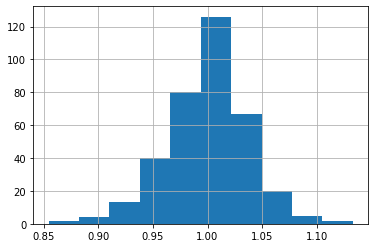

In [27]:
positive_carry_test["y"].hist()

Negative Carry Test

In [28]:
negative_carry_test = backtest_data[(backtest_data["Carry Rank"] <= 1/3)].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [29]:
negative_carry_test["x"] = negative_carry_test["Year"] + (negative_carry_test["Month"] - 1) / 12

In [30]:
negative_carry_test[["x", "y"]]

,x,y
0,1992.083333,0.999899
1,1992.166667,0.992977
2,1992.250000,0.986872
3,1992.333333,1.044906
4,1992.416667,1.010671
...,...,...
354,2021.583333,0.980413
355,2021.666667,1.041894
356,2021.750000,1.005262
357,2021.833333,0.955206


In [31]:
negative_carry_test["y_cum"] = negative_carry_test["y"].cumprod()

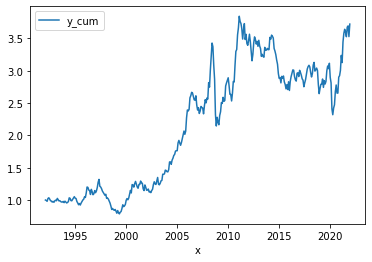

In [32]:
negative_carry_test.plot.line(x="x", y="y_cum")

In [33]:
negative_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.004411
std,0.038589
min,0.810273
25%,0.979342
50%,1.000758
75%,1.027921
max,1.117043


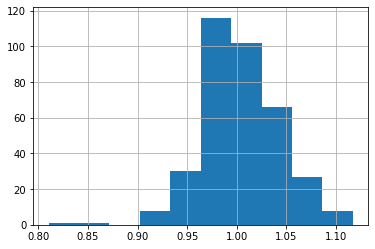

In [34]:
negative_carry_test["y"].hist()

Combined Carry Test

In [35]:
combined_carry_test = positive_carry_test[["x", "y"]].merge(negative_carry_test[["x", "y"]], on="x")

In [36]:
combined_carry_test["y"] = (2 - combined_carry_test["y_x"] + combined_carry_test["y_y"]) / 2

In [37]:
combined_carry_test[["x", "y"]]

,x,y
0,1992.083333,1.014669
1,1992.166667,0.992478
2,1992.250000,1.004614
3,1992.333333,1.018953
4,1992.416667,1.007861
...,...,...
354,2021.583333,0.967389
355,2021.666667,1.033791
356,2021.750000,0.989269
357,2021.833333,0.973071


In [38]:
combined_carry_test["y_cum"] = combined_carry_test["y"].cumprod()

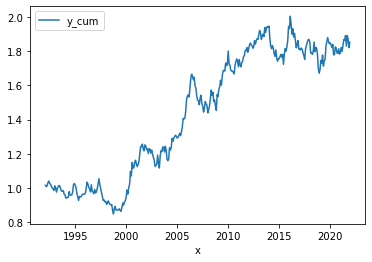

In [39]:
combined_carry_test.plot.line(x="x", y="y_cum")

In [40]:
combined_carry_test[["y"]].describe()

,y
count,359.000000
mean,1.001931
std,0.020757
min,0.952460
25%,0.987857
50%,1.000337
75%,1.014353
max,1.075004


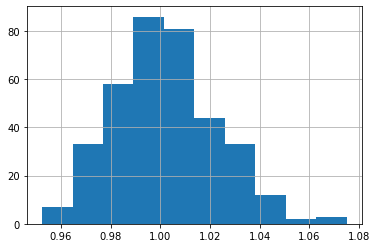

In [41]:
combined_carry_test["y"].hist()

All Carry Test

In [42]:
ew_commodity_test = backtest_data.groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [43]:
ew_commodity_test["x"] = ew_commodity_test["Year"] + (ew_commodity_test["Month"] - 1) / 12

In [44]:
ew_commodity_test[["x", "y"]]

,x,y
0,1992.083333,0.987582
1,1992.166667,1.002805
2,1992.250000,0.995651
3,1992.333333,1.024674
4,1992.416667,1.006917
...,...,...
354,2021.583333,1.005498
355,2021.666667,1.007544
356,2021.750000,1.011736
357,2021.833333,0.993376


In [45]:
ew_commodity_test["y_cum"] = ew_commodity_test["y"].cumprod()

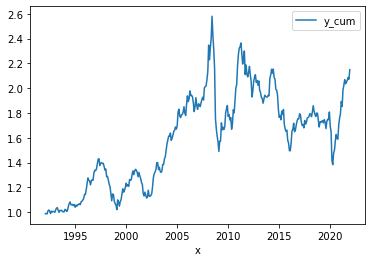

In [46]:
ew_commodity_test.plot.line(x="x", y="y_cum")

In [47]:
ew_commodity_test[["y"]].describe()

,y
count,359.000000
mean,1.002632
std,0.031397
min,0.815559
25%,0.983788
50%,1.004036
75%,1.019773
max,1.100172


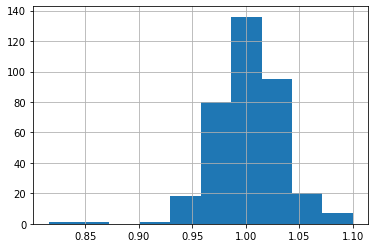

In [48]:
ew_commodity_test["y"].hist()

Look into the different percentiles and their return characteristics

In [49]:
backtest_data["Carry Rank Group"] = backtest_data["Carry Rank"].apply(lambda x: math.floor(x*10))

In [50]:
backtest_data.groupby("Carry Rank Group").agg(
    mean_return = ("c2_adj_monthly_return", "mean"),
    med_return = ("c2_adj_monthly_return", "mean"),
    min_return = ("c2_adj_monthly_return", "min"),
    max_return = ("c2_adj_monthly_return", "max"),
    std_return = ("c2_adj_monthly_return", "std")
)

,mean_return,med_return,min_return,max_return,std_return
Carry Rank Group,,,,,
0,1.004874,1.004874,0.720833,1.366957,0.076015
1,0.999441,0.999441,0.567803,1.318148,0.069635
2,1.007582,1.007582,0.625466,1.550507,0.073298
3,1.003364,1.003364,0.661273,1.313360,0.066876
4,1.002334,1.002334,0.697743,1.245527,0.065582
5,1.002898,1.002898,0.715061,1.372080,0.067490
6,1.005914,1.005914,0.449966,1.343601,0.071876
7,1.002591,1.002591,0.740697,1.367135,0.072594
8,0.997799,0.997799,0.794677,1.416961,0.069655


## Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [51]:
backtest_data["Momentum Rank"] = backtest_data.groupby(["Year", "Month"])["c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [52]:
backtest_data[backtest_data["Momentum Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

126.95741520149745

In [53]:
backtest_data[backtest_data["Momentum Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

-0.9965327882593871

Positive Momentum Test

In [54]:
positive_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [55]:
positive_momentum_test["x"] = positive_momentum_test["Year"] + (positive_momentum_test["Month"] - 1) / 12

In [56]:
positive_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.010219
1,1992.166667,1.025362
2,1992.250000,1.037839
3,1992.333333,1.050081
4,1992.416667,0.994365
...,...,...
354,2021.583333,1.008072
355,2021.666667,0.993822
356,2021.750000,0.998075
357,2021.833333,0.983189


In [57]:
positive_momentum_test["y_cum"] = positive_momentum_test["y"].cumprod()

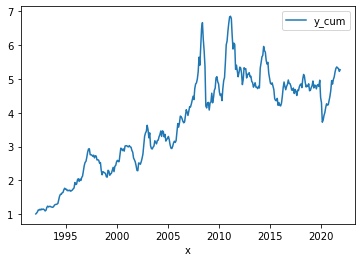

In [58]:
positive_momentum_test.plot.line(x="x", y="y_cum")

In [59]:
positive_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.005443
std,0.039776
min,0.780822
25%,0.981801
50%,1.006500
75%,1.028601
max,1.124378


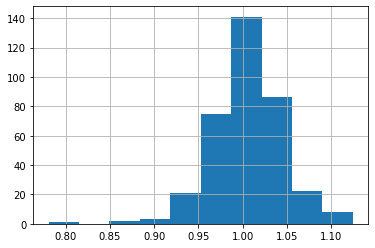

In [60]:
positive_momentum_test["y"].hist()

Negative Momentum Test

In [61]:
negative_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [62]:
negative_momentum_test["x"] = negative_momentum_test["Year"] + (negative_momentum_test["Month"] - 1) / 12

In [63]:
negative_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.973414
1,1992.166667,0.995434
2,1992.250000,0.986067
3,1992.333333,1.006750
4,1992.416667,1.038265
...,...,...
354,2021.583333,0.991425
355,2021.666667,1.004757
356,2021.750000,1.021500
357,2021.833333,0.979919


In [64]:
negative_momentum_test["y_cum"] = (2 - negative_momentum_test["y"]).cumprod()

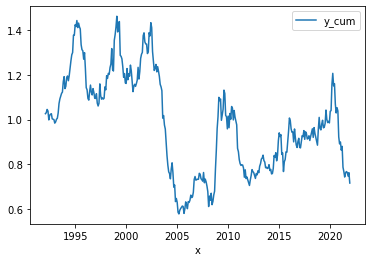

In [65]:
negative_momentum_test.plot.line(x="x", y="y_cum")

In [66]:
negative_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.000149
std,0.039479
min,0.854923
25%,0.976693
50%,1.000682
75%,1.022634
max,1.111371


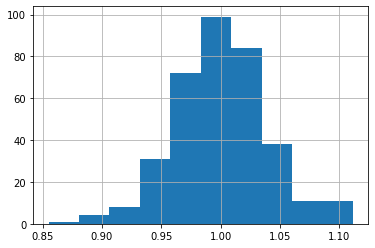

In [67]:
negative_momentum_test["y"].hist()

Combined Momentum Test

In [68]:
combined_momentum_test = negative_momentum_test[["x", "y"]].merge(positive_momentum_test[["x", "y"]], on="x")

In [69]:
combined_momentum_test["y"] = (2 - combined_momentum_test["y_x"] + combined_momentum_test["y_y"]) / 2

In [70]:
combined_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.018402
1,1992.166667,1.014964
2,1992.250000,1.025886
3,1992.333333,1.021665
4,1992.416667,0.978050
...,...,...
354,2021.583333,1.008323
355,2021.666667,0.994533
356,2021.750000,0.988287
357,2021.833333,1.001635


In [71]:
combined_momentum_test["y_cum"] = combined_momentum_test["y"].cumprod()

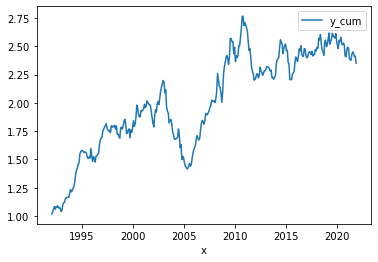

In [72]:
combined_momentum_test.plot.line(x="x", y="y_cum")

In [73]:
combined_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.002647
std,0.022978
min,0.918378
25%,0.990292
50%,1.003034
75%,1.016023
max,1.075163


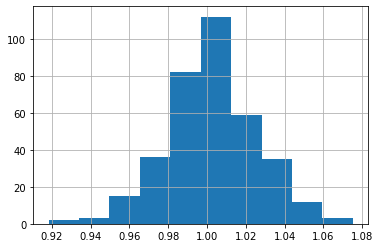

In [74]:
combined_momentum_test["y"].hist()

## Momentum-Carry Test

TODO: There are cases in which no commodities are bought/sold for a specific period. We need to deel with this in our backtest data. For instance by filling in those dates with a 0% return

Positive Carry-Momentum Test

In [75]:
positive_carry_momentum_test = backtest_data[
    (backtest_data["Carry Rank"] >= 2/3) &
    (backtest_data["Momentum Rank"] <= 1/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [76]:
positive_carry_momentum_test["x"] = positive_carry_momentum_test["Year"] + (positive_carry_momentum_test["Month"] - 1) / 12

In [77]:
positive_carry_momentum_test = positive_carry_momentum_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_carry_momentum_test.fillna(1, inplace=True)
positive_carry_momentum_test.sort_values(by="x", inplace=True)

In [78]:
positive_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,0.969078
1,1992.166667,0.864368
2,1992.250000,1.007804
3,1992.333333,0.993140
4,1992.416667,1.046338
...,...,...
347,2021.583333,1.046206
358,2021.666667,1.000000
348,2021.750000,1.045396
349,2021.833333,0.969899


In [79]:
positive_carry_momentum_test["y_cum"] = (2 - positive_carry_momentum_test["y"]).cumprod()

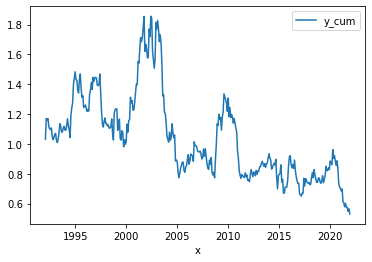

In [80]:
positive_carry_momentum_test.plot.line(x="x", y="y_cum")

In [81]:
positive_carry_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.000319
std,0.053928
min,0.822524
25%,0.969514
50%,1.002266
75%,1.030918
max,1.164435


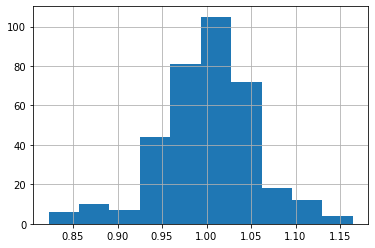

In [82]:
positive_carry_momentum_test["y"].hist()

Negative Carry-Momentum Test

In [83]:
negative_carry_momentum_test = backtest_data[
    (backtest_data["Carry Rank"] <= 1/3) &
    (backtest_data["Momentum Rank"] >= 2/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [84]:
negative_carry_momentum_test["x"] = negative_carry_momentum_test["Year"] + (negative_carry_momentum_test["Month"] - 1) / 12

In [85]:
negative_carry_momentum_test = negative_carry_momentum_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_carry_momentum_test.fillna(1, inplace=True)
negative_carry_momentum_test.sort_values(by="x", inplace=True)

In [86]:
negative_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.016308
351,1992.166667,1.000000
1,1992.250000,1.024509
2,1992.333333,1.085359
3,1992.416667,0.950311
...,...,...
346,2021.583333,1.002109
347,2021.666667,1.055939
348,2021.750000,1.001204
349,2021.833333,0.948781


In [87]:
negative_carry_momentum_test["y_cum"] = negative_carry_momentum_test["y"].cumprod()

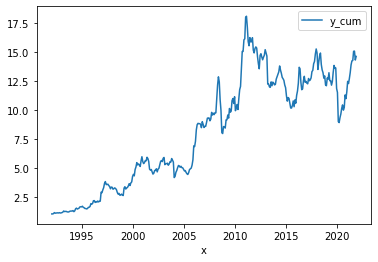

In [88]:
negative_carry_momentum_test.plot.line(x="x", y="y_cum")

In [89]:
negative_carry_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.009097
std,0.056994
min,0.756294
25%,0.976545
50%,1.007619
75%,1.038103
max,1.366957


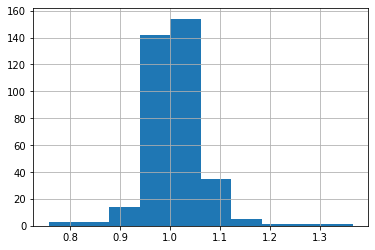

In [90]:
negative_carry_momentum_test["y"].hist()

Combined Carry Momentum Test

In [91]:
combined_carry_momentum_test = positive_carry_momentum_test[["x", "y"]].merge(negative_carry_momentum_test[["x", "y"]], on="x", how="outer")

In [92]:
combined_carry_momentum_test = combined_carry_momentum_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
combined_carry_momentum_test.fillna(1, inplace=True)
combined_carry_momentum_test.sort_values(by="x", inplace=True)

In [93]:
combined_carry_momentum_test["y"] = (2 - combined_carry_momentum_test["y_x"] + combined_carry_momentum_test["y_y"]) / 2

In [94]:
combined_carry_momentum_test[["x", "y"]]

,x,y
0,1992.083333,1.023615
1,1992.166667,1.067816
2,1992.250000,1.008352
3,1992.333333,1.046110
4,1992.416667,0.951987
...,...,...
354,2021.583333,0.977951
355,2021.666667,1.027970
356,2021.750000,0.977904
357,2021.833333,0.989441


In [95]:
combined_carry_momentum_test["y_cum"] = combined_carry_momentum_test["y"].cumprod()

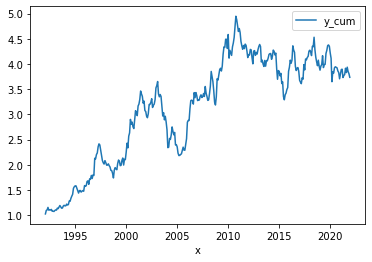

In [96]:
combined_carry_momentum_test.plot.line(x="x", y="y_cum")

In [97]:
combined_carry_momentum_test[["y"]].describe()

,y
count,359.000000
mean,1.004389
std,0.037962
min,0.867788
25%,0.981139
50%,1.002336
75%,1.026130
max,1.191457


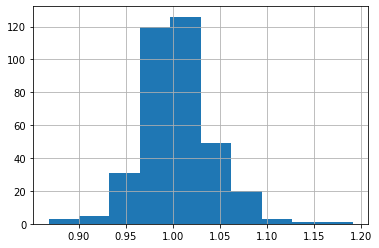

In [98]:
combined_carry_momentum_test["y"].hist()

## Carry-Momentum V2
Rather than doing a simultaneous sort as above, we now do a two-step sort where we first sort on carry & then on momentum

Positive Carry-Momentum Test

In [99]:
positive_carry_momentum_v2_test = backtest_data[
    (backtest_data["Carry Rank"] >= 2/3)
].copy().reset_index(drop=True)

In [100]:
positive_carry_momentum_v2_test["Momentum Rank"] = positive_carry_momentum_v2_test.groupby(["Year", "Month"])["c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [101]:
positive_carry_momentum_v2_test = positive_carry_momentum_v2_test[
    positive_carry_momentum_v2_test["Momentum Rank"] <= 1/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [102]:
positive_carry_momentum_v2_test["x"] = positive_carry_momentum_v2_test["Year"] + (positive_carry_momentum_v2_test["Month"] - 1) / 12

In [103]:
positive_carry_momentum_v2_test = positive_carry_momentum_v2_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_carry_momentum_v2_test.fillna(1, inplace=True)
positive_carry_momentum_v2_test.sort_values(by="x", inplace=True)

In [104]:
positive_carry_momentum_v2_test[["x", "y"]]

,x,y
0,1992.083333,0.985952
1,1992.166667,0.935614
2,1992.250000,1.007804
3,1992.333333,1.030795
4,1992.416667,1.061535
...,...,...
354,2021.583333,1.046490
355,2021.666667,0.991975
356,2021.750000,1.045818
357,2021.833333,0.984297


In [105]:
positive_carry_momentum_v2_test["y_cum"] = (2 - positive_carry_momentum_v2_test["y"]).cumprod()

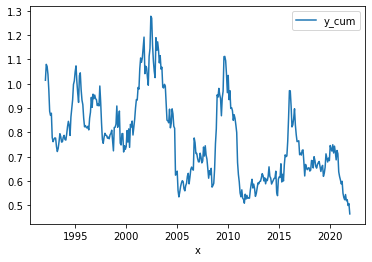

In [106]:
positive_carry_momentum_v2_test.plot.line(x="x", y="y_cum")

In [107]:
positive_carry_momentum_v2_test[["y"]].describe()

,y
count,359.000000
mean,1.000581
std,0.055731
min,0.795194
25%,0.968995
50%,1.002153
75%,1.033316
max,1.235845


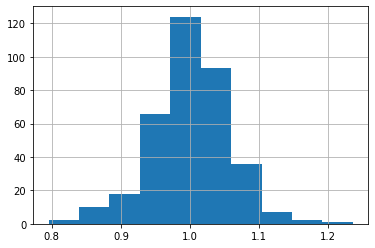

In [108]:
positive_carry_momentum_v2_test["y"].hist()

Negative Carry-Momentum Test

In [109]:
negative_carry_momentum_v2_test = backtest_data[
    (backtest_data["Carry Rank"] <= 1/3)
].copy().reset_index(drop=True)

In [110]:
negative_carry_momentum_v2_test["Momentum Rank"] = negative_carry_momentum_v2_test.groupby(["Year", "Month"])["c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [111]:
negative_carry_momentum_v2_test = negative_carry_momentum_v2_test[
    negative_carry_momentum_v2_test["Momentum Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean")).reset_index()

In [112]:
negative_carry_momentum_v2_test["x"] = negative_carry_momentum_v2_test["Year"] + (negative_carry_momentum_v2_test["Month"] - 1) / 12

In [113]:
negative_carry_momentum_v2_test = negative_carry_momentum_v2_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_carry_momentum_v2_test.fillna(1, inplace=True)
negative_carry_momentum_v2_test.sort_values(by="x", inplace=True)

In [114]:
negative_carry_momentum_v2_test[["x", "y"]]

,x,y
0,1992.083333,1.024226
1,1992.166667,0.976966
2,1992.250000,1.016037
3,1992.333333,1.054431
4,1992.416667,0.991148
...,...,...
354,2021.583333,1.009658
355,2021.666667,1.050225
356,2021.750000,1.050353
357,2021.833333,0.947089


In [115]:
negative_carry_momentum_v2_test["y_cum"] = negative_carry_momentum_v2_test["y"].cumprod()

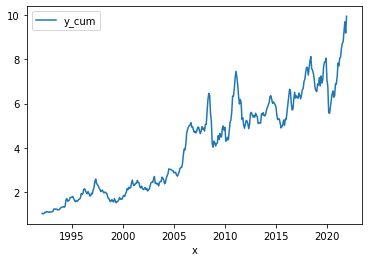

In [116]:
negative_carry_momentum_v2_test.plot.line(x="x", y="y_cum")

In [117]:
negative_carry_momentum_v2_test[["y"]].describe()

,y
count,359.000000
mean,1.007590
std,0.048365
min,0.806385
25%,0.976698
50%,1.007619
75%,1.037827
max,1.205251


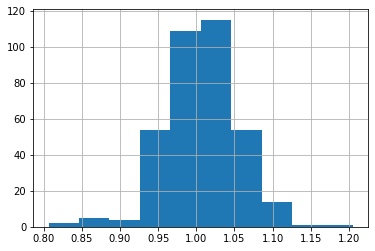

In [118]:
negative_carry_momentum_v2_test["y"].hist()

combined carry-momentum

In [119]:
combined_carry_momentum_v2_test = positive_carry_momentum_v2_test[["x", "y"]].merge(negative_carry_momentum_v2_test[["x", "y"]], on="x", how="outer")

In [120]:
combined_carry_momentum_v2_test = combined_carry_momentum_v2_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
combined_carry_momentum_v2_test.fillna(1, inplace=True)
combined_carry_momentum_v2_test.sort_values(by="x", inplace=True)

In [121]:
combined_carry_momentum_v2_test["y"] = (2 - combined_carry_momentum_v2_test["y_x"] + combined_carry_momentum_v2_test["y_y"]) / 2

In [122]:
combined_carry_momentum_v2_test[["x", "y"]]

,x,y
0,1992.083333,1.019137
1,1992.166667,1.020676
2,1992.250000,1.004116
3,1992.333333,1.011818
4,1992.416667,0.964807
...,...,...
354,2021.583333,0.981584
355,2021.666667,1.029125
356,2021.750000,1.002267
357,2021.833333,0.981396


In [123]:
combined_carry_momentum_v2_test["y_cum"] = combined_carry_momentum_v2_test["y"].cumprod()

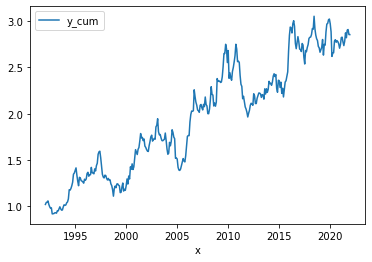

In [124]:
combined_carry_momentum_v2_test.plot.line(x="x", y="y_cum")

In [125]:
combined_carry_momentum_v2_test[["y"]].describe()

,y
count,359.000000
mean,1.003505
std,0.034116
min,0.877162
25%,0.983127
50%,1.001826
75%,1.024298
max,1.119694


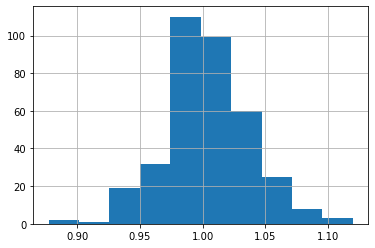

In [126]:
combined_carry_momentum_v2_test["y"].hist()

## Carry-Momentum V3
Rather than optimizing carry with momentum, we optimize momentum with carry

Negative Momentum-Carry Test

In [140]:
negative_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] <= 1/3)
].copy()
negative_momentum_carry_v3_test["pick_adj_monthly_return"] = negative_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [141]:
negative_momentum_carry_v3_test["x"] = negative_momentum_carry_v3_test["Year"] + (negative_momentum_carry_v3_test["Month"] - 1) / 12

In [142]:
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_momentum_carry_v3_test.fillna(1, inplace=True)
negative_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [143]:
negative_momentum_carry_v3_test[["x", "y"]]

,x,y
0,1992.083333,0.973007
1,1992.166667,1.006834
2,1992.250000,0.982722
3,1992.333333,0.997947
4,1992.416667,1.035959
...,...,...
354,2021.583333,1.000699
355,2021.666667,1.001853
356,2021.750000,1.020135
357,2021.833333,0.975646


In [144]:
negative_momentum_carry_v3_test["y_cum"] = (2 - negative_momentum_carry_v3_test["y"]).cumprod()

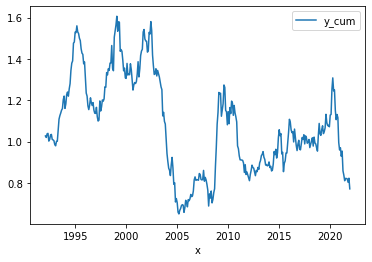

In [145]:
negative_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [146]:
negative_momentum_carry_v3_test[["y"]].describe()

,y
count,359.000000
mean,0.999947
std,0.039411
min,0.857851
25%,0.976090
50%,1.000867
75%,1.024511
max,1.116356


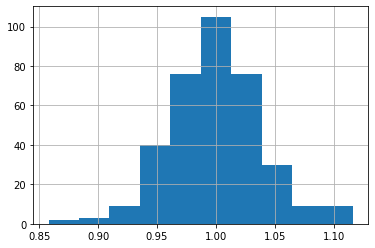

In [147]:
negative_momentum_carry_v3_test["y"].hist()

Positive Momentum-Carry Test

In [148]:
positive_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] >= 2/3)
].copy()
positive_momentum_carry_v3_test["pick_adj_monthly_return"] = positive_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.groupby(["Year", "Month"]).agg(y = ("pick_adj_monthly_return", "mean")).reset_index()

In [149]:
positive_momentum_carry_v3_test["x"] = positive_momentum_carry_v3_test["Year"] + (positive_momentum_carry_v3_test["Month"] - 1) / 12

In [150]:
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_momentum_carry_v3_test.fillna(1, inplace=True)
positive_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [151]:
positive_momentum_carry_v3_test[["x", "y"]]

,x,y
0,1992.083333,1.015966
1,1992.166667,1.032154
2,1992.250000,1.045401
3,1992.333333,1.049480
4,1992.416667,0.993558
...,...,...
354,2021.583333,1.008977
355,2021.666667,0.996984
356,2021.750000,0.998075
357,2021.833333,0.986423


In [152]:
positive_momentum_carry_v3_test["y_cum"] = positive_momentum_carry_v3_test["y"].cumprod()

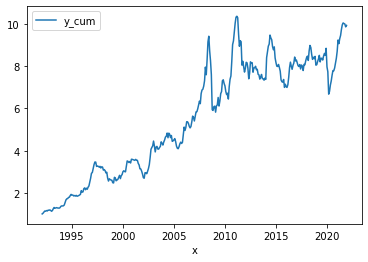

In [153]:
positive_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [154]:
positive_momentum_carry_v3_test[["y"]].describe()

,y
count,359.000000
mean,1.007229
std,0.040275
min,0.782157
25%,0.984408
50%,1.008639
75%,1.030200
max,1.139191


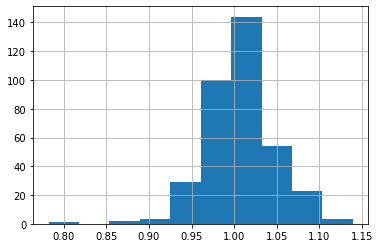

In [155]:
positive_momentum_carry_v3_test["y"].hist()

Combined Carry Momentum Test

In [156]:
combined_carry_momentum_v3_test = negative_momentum_carry_v3_test[["x", "y"]].merge(positive_momentum_carry_v3_test[["x", "y"]], on="x", how="outer")

In [157]:
combined_carry_momentum_v3_test = combined_carry_momentum_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
combined_carry_momentum_v3_test.fillna(1, inplace=True)
combined_carry_momentum_v3_test.sort_values(by="x", inplace=True)

In [158]:
combined_carry_momentum_v3_test["y"] = (2 - combined_carry_momentum_v3_test["y_x"] + combined_carry_momentum_v3_test["y_y"]) / 2

In [159]:
combined_carry_momentum_v3_test[["x", "y"]]

,x,y
0,1992.083333,1.021479
1,1992.166667,1.012660
2,1992.250000,1.031340
3,1992.333333,1.025766
4,1992.416667,0.978800
...,...,...
354,2021.583333,1.004139
355,2021.666667,0.997566
356,2021.750000,0.988970
357,2021.833333,1.005389


In [160]:
combined_carry_momentum_v3_test["y_cum"] = combined_carry_momentum_v3_test["y"].cumprod()

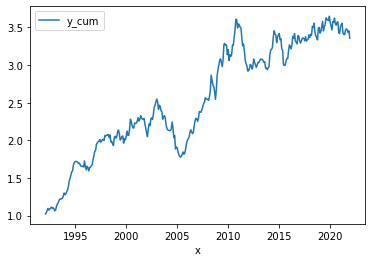

In [161]:
combined_carry_momentum_v3_test.plot.line(x="x", y="y_cum")

In [162]:
combined_carry_momentum_v3_test[["y"]].describe()

,y
count,359.000000
mean,1.003641
std,0.022965
min,0.912757
25%,0.990276
50%,1.002880
75%,1.018077
max,1.074134


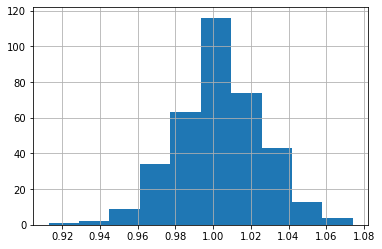

In [163]:
combined_carry_momentum_v3_test["y"].hist()

# Output Plots

In [166]:
combined_carry_test.to_csv("combined_carry_test.csv", index=False)
ew_commodity_test.to_csv("ew_test.csv", index=False)
combined_momentum_test.to_csv("combined_momentum_test.csv", index=False)
combined_carry_momentum_test.to_csv("combined_carry_momentum_test.csv", index=False)
combined_carry_momentum_v2_test.to_csv("combined_carry_momentum_v2_test.csv", index=False)
combined_carry_momentum_v3_test.to_csv("combined_carry_momentum_v3_test.csv", index=False)
negative_carry_momentum_test.to_csv("negative_carry_momentum_test.csv", index=False)

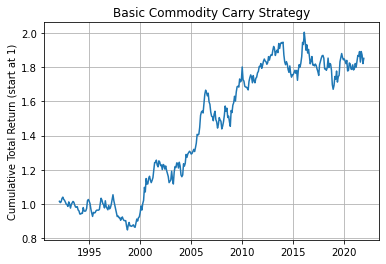

In [167]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(combined_carry_test["x"], combined_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry Strategy')

ax.grid()

fig.savefig("basic_carry_cum_return.png")
plt.show()

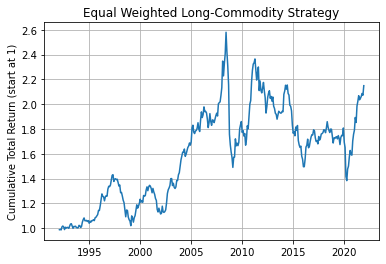

In [168]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(ew_commodity_test["x"], ew_commodity_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Equal Weighted Long-Commodity Strategy')

ax.grid()

fig.savefig("ew_long_commodity_cum_return.png")
plt.show()

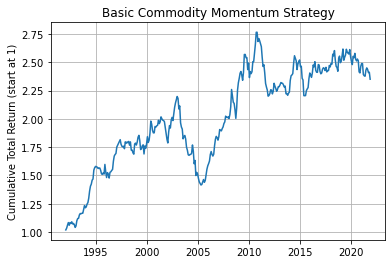

In [169]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_test["x"], combined_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Momentum Strategy')

ax.grid()

fig.savefig("basic_momentum_cum_return.png")
plt.show()

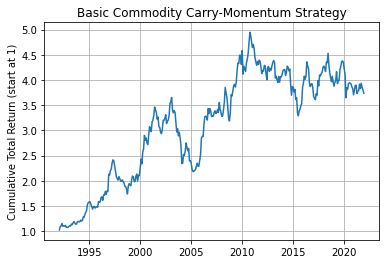

In [170]:
fig, ax = plt.subplots()
ax.plot(combined_carry_momentum_test["x"], combined_carry_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry-Momentum Strategy')

ax.grid()

fig.savefig("basic_carry_momentum_cum_return.png")
plt.show()

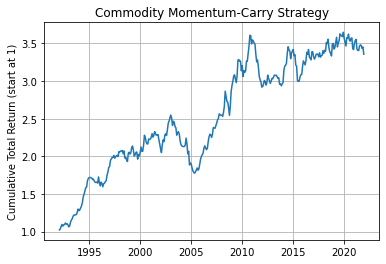

In [172]:
fig, ax = plt.subplots()
ax.plot(combined_carry_momentum_v3_test["x"], combined_carry_momentum_v3_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum-Carry Strategy')

ax.grid()

fig.savefig("momentum_carry_cum_return.png")
plt.show()